In [1]:
# Copyright 2022 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/distributed/pmap_example.ipynb)

`jax.pmap` example using JAXopt.
=========================================
The purpose of this example is to illustrate how JAXopt solvers can be easily
used for distributed training thanks to `jax.pmap`. In this case, we begin by
implementing data parallel training of a multi-class logistic regression model
on synthetic data. General aspects to pay attention to include:
* How to use `jax.lax` reduction operators such as `jax.lax.pmean` or
 `jax.lax.psum` in JAXopt solvers by using custom `value_and_grad` functions.
* How `jax.pmap` can be used to transform the solver's `update` method to easily
  write custom data-parallel training loops.

Running the notebook on Google Colab:
1. In `Change runtime type` under the menu `Runtime`, select `TPU` for the `Hardware accelerator` option.
2. Connect to the runtime and run all cells. 

NOTE: this example can be easily adapted to support TPU pod slices (e.g. `--accelerator_type v3-32`) as well as hosts with one or more GPUs attached.

In [2]:
#@markdown The number of optimization steps to perform:
MAXITER = 100  #@param{type:"integer"}
#@markdown The number of samples in the (synthetic) dataset:
NUM_SAMPLES = 50000  #@param{type:"integer"}
#@markdown The number of features in the (synthetic) dataset:
NUM_FEATURES = 784  #@param{type:"integer"}
#@markdown The number of classes in the (synthetic) dataset:
NUM_CLASSES = 10  #@param{type:"integer"}
#@markdown The stepsize for the optimizer (set to 0.0 to use line search):
STEPSIZE = 0.0  #@param{type:"number"}
#@markdown The line search approach (either `'zoom'` or `backtracking`), ignored if `STEPSIZE > 0.0`:
LINESEARCH = 'zoom'  #@param{type:"string"}

# Imports and TPU setup

In [3]:
%%capture
%pip install jaxopt flax

In [4]:
import functools
import time
from typing import Any, Callable, Tuple, Union

from absl import app
from absl import flags

from flax import jax_utils
from flax.training import common_utils

import jax
import jax.numpy as jnp
import jax.tools.colab_tpu

import jaxopt

import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets

In [5]:
jax.tools.colab_tpu.setup_tpu()
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

# Type aliases

In [6]:
Array = Union[np.ndarray, jax.Array]

# Auxiliary functions
A MWE of how all-reduce mean/sum OPs can be introduced into JAXopt solver's `update` method by overriding `jax.value_and_grad`. Note that more complex wrappers are of course possible.

In [7]:
def pmean(fun: Callable[..., Any], axis_name: str = 'b') -> Callable[..., Any]:
  """Applies `jax.lax.pmean` across `axis_name` for all of `fun`'s outputs."""
  maybe_pmean = lambda t: jax.lax.pmean(t, axis_name) if t is not None else t
  @functools.wraps(fun)
  def wrapper(*args, **kwargs):
    return jax.tree_map(maybe_pmean, fun(*args, **kwargs))
  return wrapper

A small utility to shard `Array`s across the available devices:

In [8]:
def shard_array(array: Array) -> jax.Array:
  """Shards `array` along its leading dimension."""
  return jax.device_put_sharded(
      shards=list(common_utils.shard(array)),
      devices=jax.devices())

# Custom-loop
Shows a comparison of how single-device and data-parallel SPMD differ in a vanilla JAXopt custom training loop

In [9]:
def fit(
    data: Tuple[Array, Array],
    init_params: Array,
    stepsize: float = 0.0,
    linesearch: str = 'zoom',
    use_pmap: bool = False,
) -> Tuple[np.ndarray, np.ndarray, float]:
  """Fits a multi-class logistic regression model for demonstration purposes.

  Args:
    data: A tuple `(X, y)` with the training covariates and categorical labels,
      respectively.
    init_params: The initial value of the model's weights.
    stepsize: The stepsize to use for the solver. If set to `0`, linesearch will
      be used instead.
    linesearch: The linesearch algorithm to use. If `stepsize > 0`, linsearch
      will be disabled.
    use_pmap: Whether to distribute the computation across replicas or use only
      the first device available.
  
  Returns:
    The per-step errors and runtimes, as well as the JIT-compile time for the
    solver's `update` function.
  """
  # Value and grad of the objective function for the solver.
  value_and_grad_fun = jax.value_and_grad(jaxopt.objective.multiclass_logreg)
  # When `jax.pmap`ing the computation, use JAXopt's option to provide a custom
  # `value_and_grad` function to include the desired reduction operators. For
  # example, here we decide to average across replicas.
  if use_pmap:
    value_and_grad_fun = pmean(value_and_grad_fun)

  # To override `jax.value_and_grad` in a JAXopt solver, set the flag 
  # `value_and_grad` to `True` and pass the custom implementation of the
  # `value_and_grad` function as `fun`.
  solver = jaxopt.LBFGS(fun=value_and_grad_fun,
                        value_and_grad=True,
                        stepsize=stepsize,
                        linesearch=linesearch)
  # As usual, apply the `jax.pmap` transform to the function to be computed in
  # a distributed manner (the solver's `update` method in this case). Otherwise,
  # we JIT compile it.
  if use_pmap:
    update = jax.pmap(solver.update, axis_name='b')
  else:
    update = jax.jit(solver.update)

  # Initialize solver state.
  state = solver.init_state(init_params, data=data)
  params = init_params
  # If using `pmap` for data-parallel training, model parameters are typically
  # replicated across devices.
  if use_pmap:
    params, state = jax_utils.replicate((params, state))
  
  # Finally, since in this demo we are *not* using mini-batches, it pays off to
  # transfer data to the device beforehand. Otherwise, host-to-device transfers
  # occur in each update. This is true regardless of whether we use distributed
  # or single-device computation.
  if use_pmap:  # Shards data and moves it to device,
    data = jax.tree_map(shard_array, data)
  else:  # Just move data to device.
    data = jax.tree_map(jax.device_put, data)

  # Pre-compiles update, preventing it from affecting step times.
  tic = time.time()
  _ = update(params, state, data)
  compile_time = time.time() - tic

  outer_tic = time.time()

  step_times = np.zeros(MAXITER)
  errors = np.zeros(MAXITER)
  for it in range(MAXITER):
    tic = time.time()
    params, state = update(params, state, data)
    jax.tree_map(lambda t: t.block_until_ready(), (params, state))
    step_times[it] = time.time() - tic
    errors[it] = (jax_utils.unreplicate(state.error).item()
                  if use_pmap else state.error.item())

  print(
      f'Total time elapsed with {linesearch} linesearch and pmap = {use_pmap}:',
      round(time.time() - outer_tic, 2), 'seconds.')

  return errors, step_times, compile_time

# Boilerplate
Creates dataset, calls `fit` with and without `jax.pmap`, makes figures.

In [10]:
def run():
  """Boilerplate to run the demo experiment."""
  data = datasets.make_classification(n_samples=NUM_SAMPLES,
                                      n_features=NUM_FEATURES,
                                      n_classes=NUM_CLASSES,
                                      n_informative=50,
                                      random_state=0)
  init_params = jnp.zeros([NUM_FEATURES, NUM_CLASSES])
  
  errors, step_times, compile_time = {}, {}, {}

  for use_pmap in (True, False):
    exp_name: str = f"{'with' if use_pmap else 'without'}_pmap"
    _errors, _step_times, _compile_time = fit(data=data,
                                              init_params=init_params,
                                              stepsize=STEPSIZE,
                                              linesearch=LINESEARCH,
                                              use_pmap=use_pmap)
    errors[exp_name] = _errors
    step_times[exp_name] = _step_times
    compile_time[exp_name] = _compile_time

  plt.figure(figsize=(10, 6.18))
  for use_pmap in (True, False):
    exp_name: str = f"{'with' if use_pmap else 'without'}_pmap"
    plt.plot(jnp.arange(MAXITER), errors[exp_name], label=exp_name)
  plt.xlabel('Iterations', fontsize=16)
  plt.ylabel('Gradient error', fontsize=16)
  plt.yscale('log')
  plt.legend(loc='best', fontsize=16)
  plt.title(f'NUM_SAMPLES = {NUM_SAMPLES}, NUM_FEATURES = {NUM_FEATURES}',
            fontsize=22)

  plt.figure(figsize=(10, 6.18))
  for use_pmap in (True, False):
    exp_name: str = f"{'with' if use_pmap else 'without'}_pmap"
    plt.plot(jnp.arange(MAXITER), step_times[exp_name], label=exp_name)
  plt.xlabel('Iterations', fontsize=16)
  plt.ylabel('Step time', fontsize=16)
  plt.legend(loc='best', fontsize=16)
  plt.title(f'NUM_SAMPLES = {NUM_SAMPLES}, NUM_FEATURES = {NUM_FEATURES}',
            fontsize=22)

  return errors, step_times, compile_time

# Main

num_samples: 50000
num_features: 784
num_features: 10
maxiter: 100
stepsize: 0.0
linesearch (ignored if `stepsize` > 0): zoom

Total time elapsed with zoom linesearch and pmap = True: 5.9 seconds.
Total time elapsed with zoom linesearch and pmap = False: 20.44 seconds.
Average speed-up (ignoring compile): 7.17


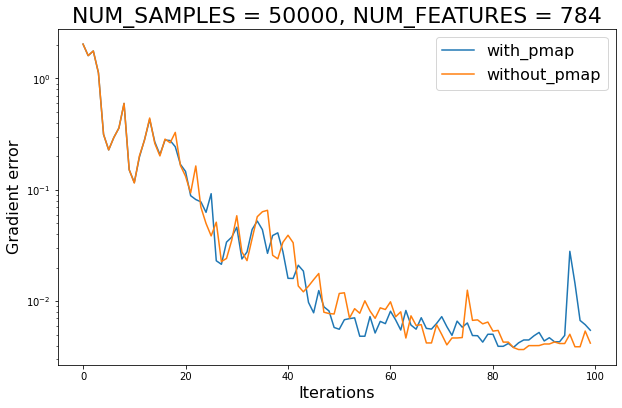

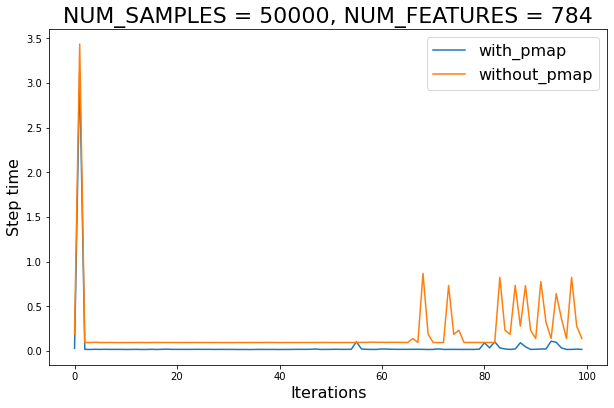

In [11]:
print("num_samples:", NUM_SAMPLES)
print("num_features:", NUM_FEATURES)
print("num_features:", NUM_CLASSES)
print("maxiter:", MAXITER)
print("stepsize:", STEPSIZE)
print("linesearch (ignored if `stepsize` > 0):", LINESEARCH)
print()

errors, step_times, compile_time = run()
print('Average speed-up (ignoring compile):',
      round((step_times['without_pmap'] / step_times['with_pmap']).mean(), 2))